In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/initialization')
CONFIG_PATH = os.path.join(ROOT, 'pytorch/configs/abc_parameterizations/fc_abc.yaml')

In [18]:
import sys
sys.path.append(ROOT)

In [19]:
import torch

from utils.tools import read_yaml, set_random_seeds
from utils.plot.abc_parameterizations.initializations import *
from pytorch.configs.model import ModelConfig
from pytorch.configs.base import BaseConfig
from pytorch.models.abc_params.fully_connected import ntk, ip, muP, ipllr
from pytorch.models.abc_params.fully_connected.standard_fc_ip import StandardFCIP

### Load basic configuration and define variables 

In [20]:
L = 5
SEED = 42

set_random_seeds(SEED)  # set random seed for reproducibility
config_dict = read_yaml(CONFIG_PATH)

config_dict['architecture']['n_layers'] = L + 1
base_model_config = ModelConfig(config_dict)

In [21]:
n_trials = 200
widths = [25, 50, 128, 256, 512, 750, 1024, 1200, 1400]
x = 2 * torch.rand(base_model_config.architecture["input_size"], requires_grad=False) - 1

# 1. With ReLU

## NTK 

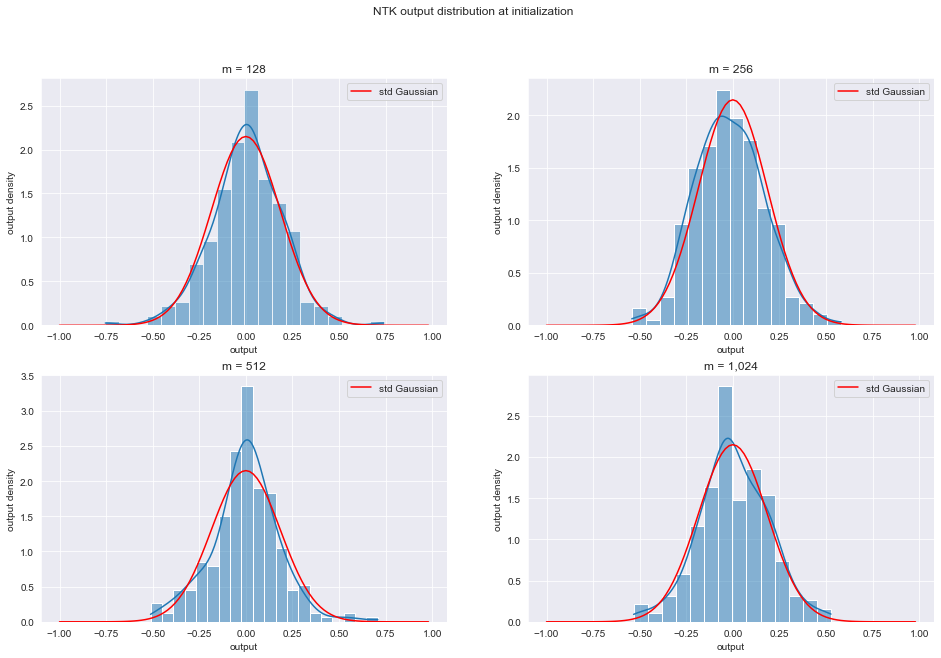

In [29]:
ntk_n_trials = 250
ntk_widths = [128, 256, 512, 1024]
fig_path = os.path.join(FIGURES_DIR, 'ntk_outputs_dist_L={}.png'.format(L))
plot_init_outputs_dist(fig_path, 'NTK', ntk.FCNTK, ntk_n_trials, ntk_widths, base_model_config, x=x, 
                       figsize=(16,10))

### muP

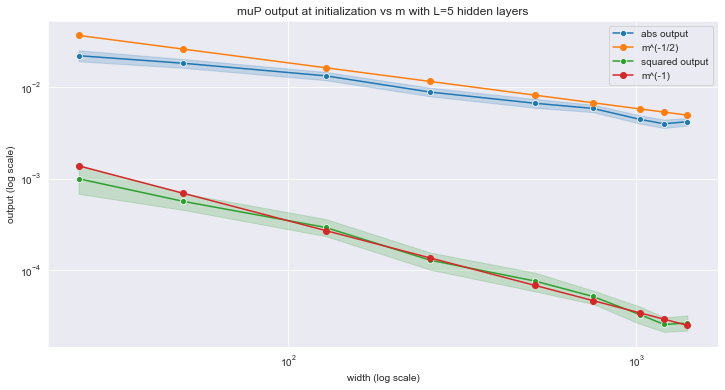

In [25]:
fig_path = os.path.join(FIGURES_DIR, 'muP_outputs_L={}.png'.format(L))
results_df = plot_init_outputs_vs_m(fig_path, 'muP', muP.FCmuP, n_trials, widths, base_model_config, x=x)

### IP

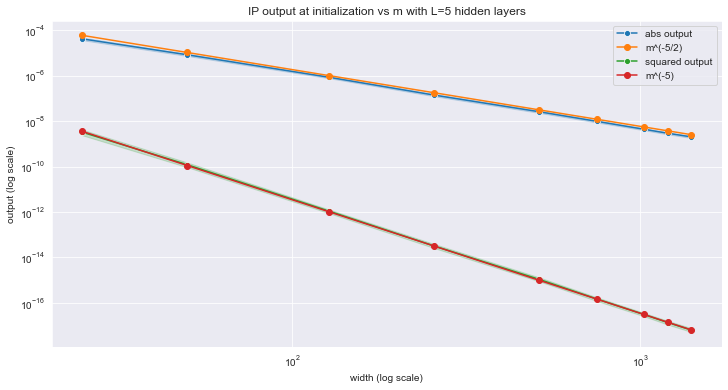

In [26]:
fig_path = os.path.join(FIGURES_DIR, 'ip_outputs_L={}.png'.format(L))
results_df = plot_init_outputs_vs_m(fig_path, 'IP', ip.FCIP, n_trials, widths, base_model_config, x=x, c=0.)

### Standard IP

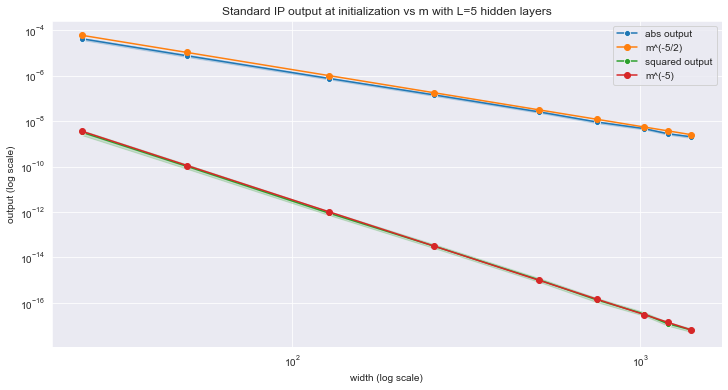

In [27]:
fig_path = os.path.join(FIGURES_DIR, 'standard_ip_outputs_L={}.png'.format(L))
results_df = plot_init_outputs_vs_m(fig_path, 'Standard IP', StandardFCIP, n_trials, widths, base_model_config, x=x)

### IP-LLR

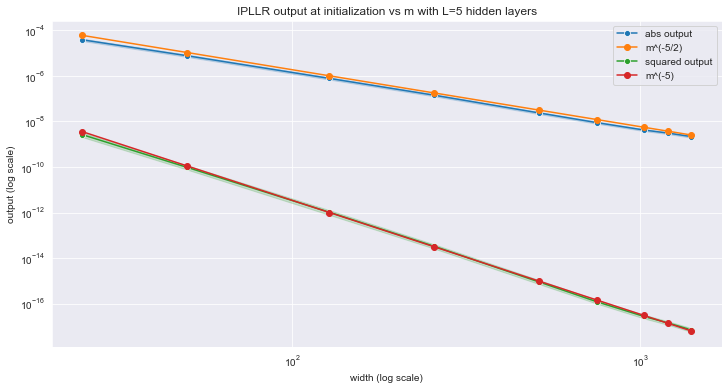

In [28]:
config = deepcopy(base_model_config)
scheduler_config = {'name': 'warmup_switch',
                    'params':{'n_warmup_steps': 1,
                              'calibrate_base_lr': False,
                              'default_calibration': False}}
config.scheduler = BaseConfig(scheduler_config)
fig_path = os.path.join(FIGURES_DIR, 'ipllr_outputs_L={}.png'.format(L))
results_df = plot_init_outputs_vs_m(fig_path, 'IPLLR', ipllr.FcIPLLR, n_trials, widths, config, x=x)

# 2. With GeLU

### var = 2

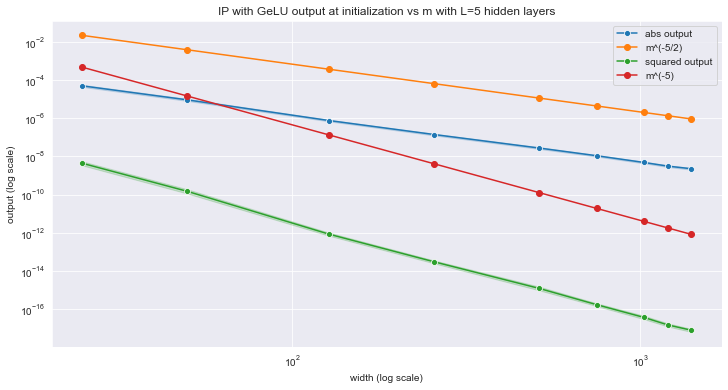

In [12]:
# default value for variance is 2.0
config = deepcopy(base_model_config)
config.activation.name = "gelu"
fig_path = os.path.join(FIGURES_DIR, 'ip_outputs_gelu_var_2_L={}.png'.format(L))
results_df = plot_init_outputs_vs_m(fig_path, 'IP with GeLU', ip.FCIP, n_trials, widths, config, x=x, 
                                    c=0.)

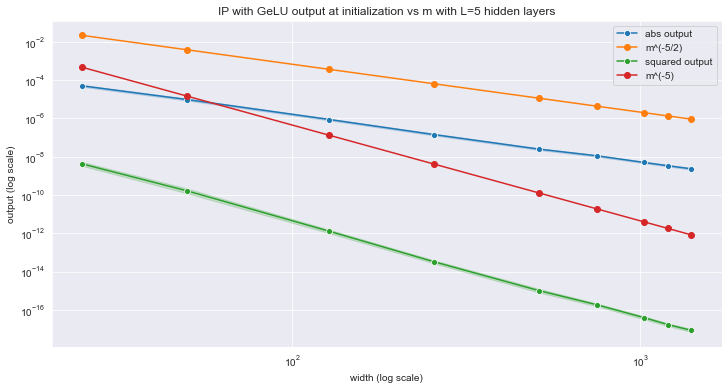

In [13]:
# default value for variance is 2.0
config = deepcopy(base_model_config)
config.activation.name = "gelu"
fig_path = os.path.join(FIGURES_DIR, 'ip_outputs_gelu_var_2_L={}.png'.format(L))
results_df = plot_init_outputs_vs_m(fig_path, 'IP with GeLU', ip.FCIP, n_trials, widths, config, x=x, 
                                    c=0.)

### var = 4

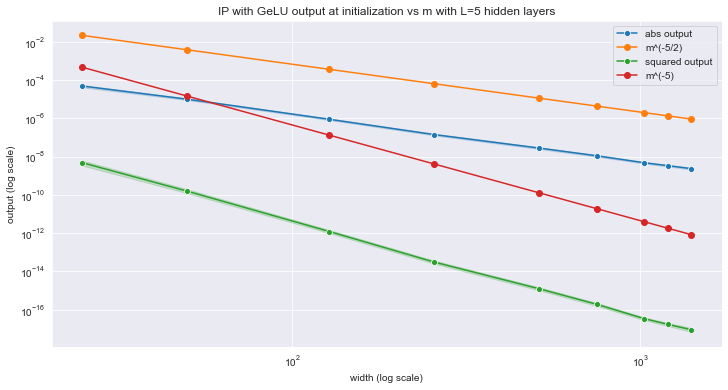

In [14]:
var = 4.0
config = deepcopy(base_model_config)
config.activation.name = "gelu"
config.initializer.params["var"] = var
fig_path = os.path.join(FIGURES_DIR, 'ip_outputs_gelu_var_4_L={}.png'.format(L))
results_df = plot_init_outputs_vs_m(fig_path, 'IP with GeLU', ip.FCIP, n_trials, widths, config, x=x, 
                                    c=0.)

# 3. With ELU

### var = 2

In [15]:
# default value for variance is 2.0
config = deepcopy(base_model_config)
config.activation.name = "elu"
fig_path = os.path.join(FIGURES_DIR, 'ip_outputs_elu_var_2_L={}.png'.format(L))
results_df = plot_init_outputs_vs_m(fig_path, 'IP with ELU', ip.FCIP, n_trials, widths, config, x=x, 
                                    c=0.)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



### var = 1

In [ ]:
var = 1.0
config = deepcopy(base_model_config)
config.activation.name = "elu"
config.initializer.params["var"] = var
fig_path = os.path.join(FIGURES_DIR, 'ip_outputs_elu_var_1_L={}.png'.format(L))
results_df = plot_init_outputs_vs_m(fig_path, 'IP with ELU', ip.FCIP, n_trials, widths, config, x=x, 
                                    c=0.)